In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load dataset
data = pd.read_csv('../Data/Data.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(17731, 20)


,Unnamed: 0,Chargingevent,CPID,Connector,Occupancy Status,StartDate,StartTime,EndDate,EndTime,StartDate_num,StartTime_num,EndDate_num,EndTime_num,duration,TotalkWh,Site,Group,Model,weekday,charger_id
0,1347,7120839,50338,1,1,2018-03-23,12:35:00,2018-03-23,13:03:00,43182,12.583333,43182,13.050000,28.0,2.951,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
1,8870,7120839,50338,1,0,2018-03-23,13:03:00,2018-03-23,13:13:00,43182,13.050000,43182,13.216667,28.0,2.951,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
2,1340,7121028,50338,1,1,2018-03-23,13:13:00,2018-03-23,13:20:00,43182,13.216667,43182,13.333333,7.0,0.765,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
3,8872,7121028,50338,1,0,2018-03-23,13:20:00,2018-05-01,15:51:00,43182,13.333333,43221,15.850000,7.0,0.765,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
4,5143,7221636,50338,1,1,2018-05-01,15:51:00,2018-05-01,16:18:00,43221,15.850000,43221,16.300000,27.0,8.053,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,2,1


### Seperate dataset into train and test

In [3]:
data.columns

Index(['Unnamed: 0', 'Chargingevent', 'CPID', 'Connector', 'Occupancy Status',
       'StartDate', 'StartTime', 'EndDate', 'EndTime', 'StartDate_num',
       'StartTime_num', 'EndDate_num', 'EndTime_num', 'duration', 'TotalkWh',
       'Site', 'Group', 'Model', 'weekday', 'charger_id'],
      dtype='object')

In [4]:
# Let's seperate into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns = ['Unnamed: 0', 'Occupancy Status'], axis = 1), # Predictive Variables
    data['Occupancy Status'], # Target
    test_size = 0.2,
    random_state = 0
)

X_train.shape, X_test.shape

((14184, 18), (3547, 18))

### Feature Engineering

### Missing Values

In [5]:
data.isna().sum()

Unnamed: 0          0
Chargingevent       0
CPID                0
Connector           0
Occupancy Status    0
StartDate           0
StartTime           0
EndDate             0
EndTime             0
StartDate_num       0
StartTime_num       0
EndDate_num         0
EndTime_num         0
duration            0
TotalkWh            0
Site                0
Group               0
Model               0
weekday             0
charger_id          0
dtype: int64

In [6]:
data['Model'].unique()

array(['APT Triple Rapid Charger', 'APT Dual Rapid Charger',
       'APT 50kW Raption'], dtype=object)

### Detecting Outliers 

In [7]:
import plotly.express as px
import seaborn as sns

In [8]:
Outliers_List = ['StartDate_num', 'StartTime_num', 'EndDate_num', 'EndTime_num', 'duration','TotalkWh']

In [9]:
def find_Outliers(Outliers_List):

    for x in Outliers_List:
        q1 = data[x].quantile(0.25)
        q3 = data[x].quantile(0.75)

        IQR = q3 - q1
        outliers = data[x][((data[x]<(q1-1.5*IQR)) | (data[x]>(q3+1.5*IQR)))]

        print('Number of Outliers in ' + x + ": " + str(len(outliers)))

In [10]:
find_Outliers(Outliers_List)

Number of Outliers in StartDate_num: 0
Number of Outliers in StartTime_num: 0
Number of Outliers in EndDate_num: 0
Number of Outliers in EndTime_num: 0
Number of Outliers in duration: 265
Number of Outliers in TotalkWh: 176


### Plotting Outliers

In [11]:
def Outliers(data, x):
    ax = sns.boxplot(
    data = data, x = x,
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"})
    
    ax.set(xlabel = None)
    ax.set(title = x)
    sns.set_style("whitegrid")


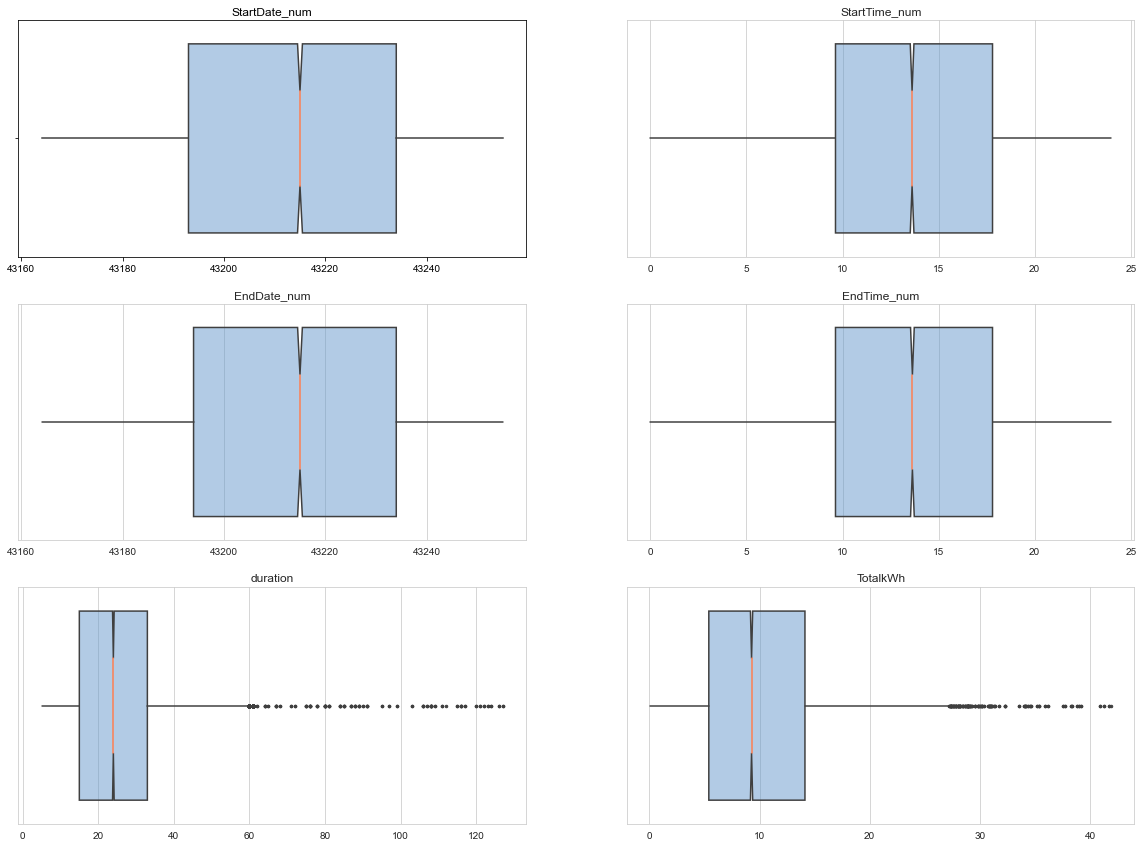

In [12]:
plt.figure(figsize=(20, 20)) 
for i in range(0, 6):
    plt.subplot(4, 2, i+1)
    Outliers(data, Outliers_List[i])

### Capping the outliers
* We essentially set a limit for the min and max outlier values. Anything above or below the cap gets set to the capped min or max respectively.

In [13]:
def cap_outliers(Outliers_List):
    for x in Outliers_List:
        upper_limit = data[x].mean() + 3*data[x].std()
        lower_limit = data[x].mean() - 3*data[x].std()

        data[x] = np.where(data[x] > upper_limit, upper_limit, np.where(data[x] < lower_limit, lower_limit, data[x]))

In [14]:
cap_outliers(Outliers_List)

### Boxplot after Capping the outliers

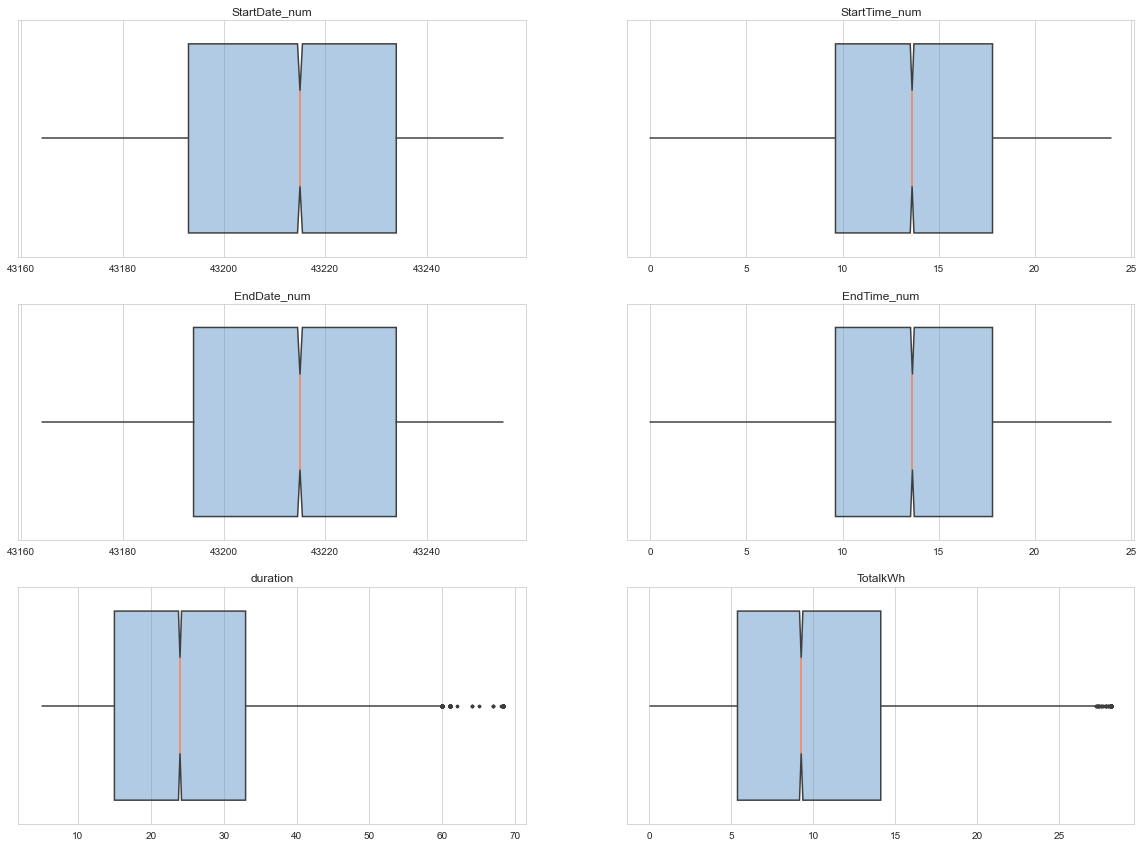

In [15]:
plt.figure(figsize=(20, 20)) 
for i in range(0, 6):
    plt.subplot(4, 2, i+1)
    Outliers(data, Outliers_List[i])

### Another Method of replacing outliers: Using imputation as if they were missing values
* This technique handles outliers is similar to capping the values. Instead of using a capping calculation, use whatever imputation technique is being used on the missing values. 

In [16]:
def impute_outliers_IQR(Outliers_List):
    for x in Outliers_List:
        q1 = data[x].quantile(0.25)
        q3 = data[x].quantile(0.75)

        IQR = q3 - q1
        upper = data[x][~(data[x]>(q3+1.5*IQR))].max()
        lower = data[x][~(data[x]<(q1-1.5*IQR))].min()  

        data[x] = np.where(data[x] > upper, data[x].mean(), np.where(data[x] < lower, data[x].mean(), data[x]))

In [17]:
impute_outliers_IQR(Outliers_List)

### Boxplot after Capping the outliers

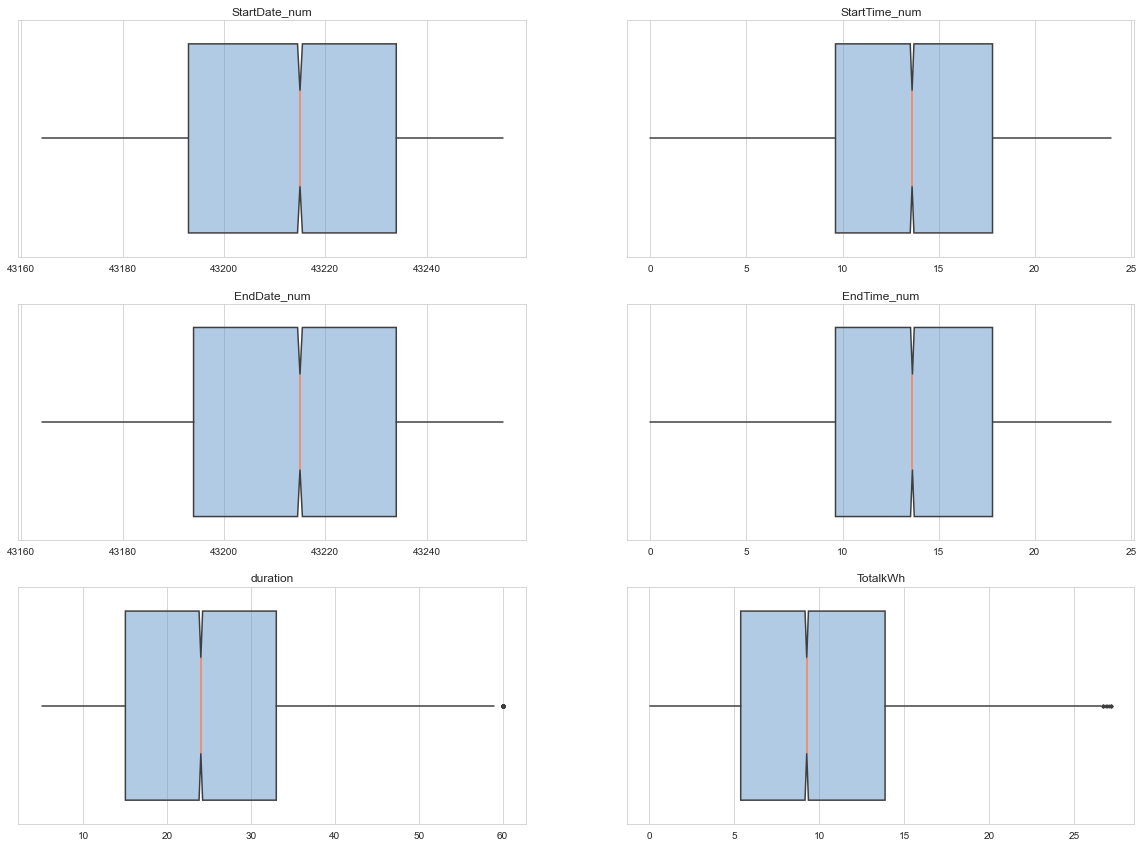

In [18]:
plt.figure(figsize=(20, 20)) 
for i in range(0, 6):
    plt.subplot(4, 2, i+1)
    Outliers(data, Outliers_List[i])

### Encoding Categorical Features

### Feature Selection 

In [19]:
data.head()

,Unnamed: 0,Chargingevent,CPID,Connector,Occupancy Status,StartDate,StartTime,EndDate,EndTime,StartDate_num,StartTime_num,EndDate_num,EndTime_num,duration,TotalkWh,Site,Group,Model,weekday,charger_id
0,1347,7120839,50338,1,1,2018-03-23,12:35:00,2018-03-23,13:03:00,43182.0,12.583333,43182.0,13.050000,28.0,2.951,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
1,8870,7120839,50338,1,0,2018-03-23,13:03:00,2018-03-23,13:13:00,43182.0,13.050000,43182.0,13.216667,28.0,2.951,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
2,1340,7121028,50338,1,1,2018-03-23,13:13:00,2018-03-23,13:20:00,43182.0,13.216667,43182.0,13.333333,7.0,0.765,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
3,8872,7121028,50338,1,0,2018-03-23,13:20:00,2018-05-01,15:51:00,43182.0,13.333333,43221.0,15.850000,7.0,0.765,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,5,1
4,5143,7221636,50338,1,1,2018-05-01,15:51:00,2018-05-01,16:18:00,43221.0,15.850000,43221.0,16.300000,27.0,8.053,"Social Work Building, Jack Martin Way, Dundee",APT Controls; CYC; ChargePlace Scotland; Dunde...,APT Triple Rapid Charger,2,1


In [20]:
data['Site'].unique()

array(['Social Work Building, Jack Martin Way, Dundee',
       'Public Works Dept, Clepington Rd. Dundee',
       'Greenmarket Multi Car Park, Dundee', 'Dundee Ice Arena, Dundee',
       'Queen Street Car Park, Broughty Ferry, Dundee',
       'Lochee Charging Hub, Dundee',
       '***TEST SITE*** Charge Your Car HQ'], dtype=object)

In [21]:
data['Group'].unique()

array(['APT Controls; CYC; ChargePlace Scotland; Dundee City Council'],
      dtype=object)

In [22]:
data['Model'].unique()

array(['APT Triple Rapid Charger', 'APT Dual Rapid Charger',
       'APT 50kW Raption'], dtype=object)

### Label Encoder

In [23]:
Label_lst = ["Site", "Group", "Model"]

In [24]:
from sklearn.preprocessing import LabelEncoder

def Label_Encoder():
    for x in Label_lst:
        # Create a LabelEncoder object
        le = LabelEncoder()

        # Fit and transform the data
        data[x] = le.fit_transform(data[x])


        # Print the mapping between categorical and numerical values
        print(f'{x}: {dict(zip(le.classes_, le.transform(le.classes_)))}')


In [25]:
Label_Encoder()

Site: {'***TEST SITE*** Charge Your Car HQ': 0, 'Dundee Ice Arena, Dundee': 1, 'Greenmarket Multi Car Park, Dundee': 2, 'Lochee Charging Hub, Dundee': 3, 'Public Works Dept, Clepington Rd. Dundee': 4, 'Queen Street Car Park, Broughty Ferry, Dundee': 5, 'Social Work Building, Jack Martin Way, Dundee': 6}
Group: {'APT Controls; CYC; ChargePlace Scotland; Dundee City Council': 0}
Model: {'APT 50kW Raption': 0, 'APT Dual Rapid Charger': 1, 'APT Triple Rapid Charger': 2}


#### **Note:** Since Group column has only one value which is `{'APT Controls; CYC; ChargePlace Scotland; Dundee City Council': 0}`, it makes sense to drop the column, since it  does not provide any useful information for analysis, as it contains no variation or diversity in the data. 

In [26]:
data.drop(columns = ['Group'], axis = 1, inplace = True)

In [27]:
data.head()

,Unnamed: 0,Chargingevent,CPID,Connector,Occupancy Status,StartDate,StartTime,EndDate,EndTime,StartDate_num,StartTime_num,EndDate_num,EndTime_num,duration,TotalkWh,Site,Model,weekday,charger_id
0,1347,7120839,50338,1,1,2018-03-23,12:35:00,2018-03-23,13:03:00,43182.0,12.583333,43182.0,13.050000,28.0,2.951,6,2,5,1
1,8870,7120839,50338,1,0,2018-03-23,13:03:00,2018-03-23,13:13:00,43182.0,13.050000,43182.0,13.216667,28.0,2.951,6,2,5,1
2,1340,7121028,50338,1,1,2018-03-23,13:13:00,2018-03-23,13:20:00,43182.0,13.216667,43182.0,13.333333,7.0,0.765,6,2,5,1
3,8872,7121028,50338,1,0,2018-03-23,13:20:00,2018-05-01,15:51:00,43182.0,13.333333,43221.0,15.850000,7.0,0.765,6,2,5,1
4,5143,7221636,50338,1,1,2018-05-01,15:51:00,2018-05-01,16:18:00,43221.0,15.850000,43221.0,16.300000,27.0,8.053,6,2,2,1


#### **Note:** Since we already have columns such as `StartDate_num`, `StartTime_num`, `EndDate_num`, `EndTime_num` representing the columns `StartDate`, `StartTime`, `EndDate`, `EndTime` respectively. It's quite obivous to remove these columns

### Dropping columns `StartDate`, `StartTime`, `EndDate`, `EndTime`

In [28]:
data.drop(columns = ['StartDate', 'StartTime', 'EndDate', 'EndTime'], axis = 1, inplace = True)

In [29]:
data.head()

,Unnamed: 0,Chargingevent,CPID,Connector,Occupancy Status,StartDate_num,StartTime_num,EndDate_num,EndTime_num,duration,TotalkWh,Site,Model,weekday,charger_id
0,1347,7120839,50338,1,1,43182.0,12.583333,43182.0,13.050000,28.0,2.951,6,2,5,1
1,8870,7120839,50338,1,0,43182.0,13.050000,43182.0,13.216667,28.0,2.951,6,2,5,1
2,1340,7121028,50338,1,1,43182.0,13.216667,43182.0,13.333333,7.0,0.765,6,2,5,1
3,8872,7121028,50338,1,0,43182.0,13.333333,43221.0,15.850000,7.0,0.765,6,2,5,1
4,5143,7221636,50338,1,1,43221.0,15.850000,43221.0,16.300000,27.0,8.053,6,2,2,1


### Autocorrelation and Partial Autocorrelation using Heatmap

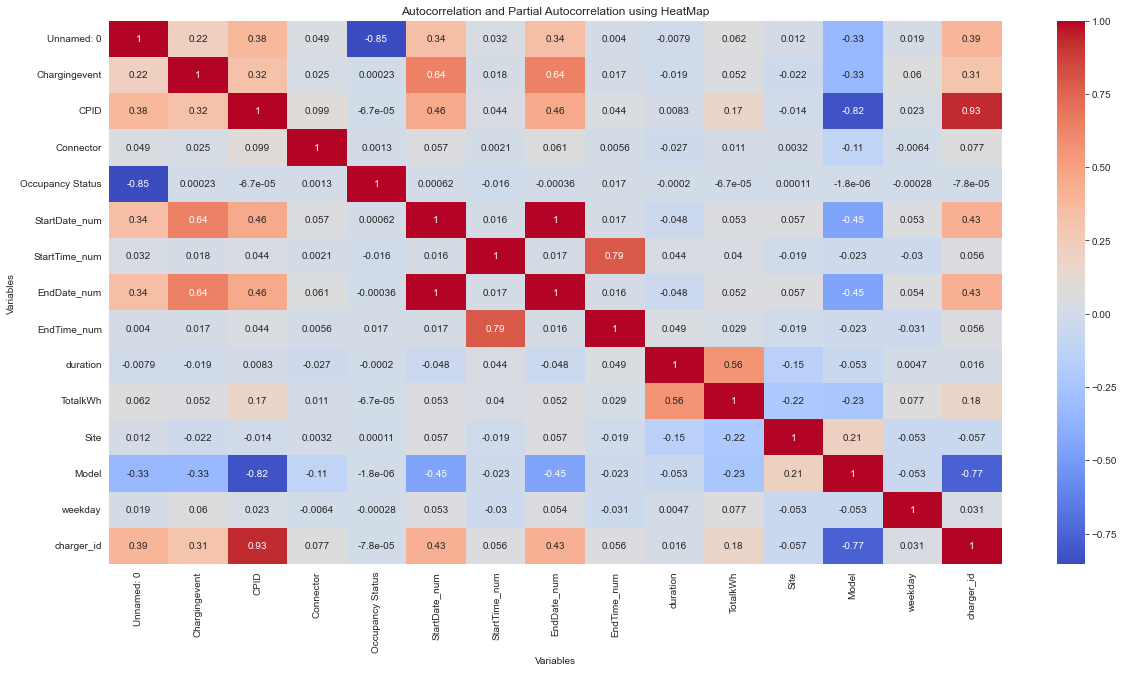

In [30]:
# Compute the correlation matrix
corr_matrix = data.corr()

# Create a heatmap 
plt.figure(figsize = (20 , 10))
sns.heatmap(corr_matrix, cmap = 'coolwarm', annot = True)

# Add Labels
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.title("Autocorrelation and Partial Autocorrelation using HeatMap")
plt.show()

In [31]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(col_corr)

In [32]:
correlation(data , 0.70)

{'charger_id', 'EndDate_num', 'EndTime_num'}


In [33]:
data.shape

(17731, 12)

In [34]:
data.head()

,Unnamed: 0,Chargingevent,CPID,Connector,Occupancy Status,StartDate_num,StartTime_num,duration,TotalkWh,Site,Model,weekday
0,1347,7120839,50338,1,1,43182.0,12.583333,28.0,2.951,6,2,5
1,8870,7120839,50338,1,0,43182.0,13.050000,28.0,2.951,6,2,5
2,1340,7121028,50338,1,1,43182.0,13.216667,7.0,0.765,6,2,5
3,8872,7121028,50338,1,0,43182.0,13.333333,7.0,0.765,6,2,5
4,5143,7221636,50338,1,1,43221.0,15.850000,27.0,8.053,6,2,2


### Splitting the data into X and y

In [35]:
X = data.drop(columns = ['Occupancy Status'])
y = data['Occupancy Status']

### Feature Selection
#### Following Feature Selection Models are used:
    1. SelectKBest
    2. Feature Importance(ExtraTreesClassifier)
    3. Information Gain

### 1. Applying SelectKBest Algorithm

In [36]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# chi2 is used to apply the statistical analysis
# What it does is, it makes sure that the p <= 0.5

In [37]:
ordered_rank_features = SelectKBest(score_func = chi2, k = 10)
# K is basically the top 10 features
ordered_features = ordered_rank_features.fit(X, y)

In [38]:
df_scores = pd.DataFrame(ordered_features.scores_ , columns = ['Score'])
df_columns = pd.DataFrame(X.columns)

In [39]:
features_rank = pd.concat([df_columns , df_scores] , axis= 1)

In [40]:
features_rank.columns = ['Features' , 'Scores']
features_rank.nlargest(n = 12, columns = ['Scores'])

,Features,Scores
0,Unnamed: 0,7.075943e+07
1,Chargingevent,9.953958e+01
5,StartTime_num,1.195955e+01
6,duration,4.545958e-03
10,weekday,1.362096e-03
3,Connector,4.826172e-04
2,CPID,3.678459e-04
7,TotalkWh,2.488199e-04
8,Site,1.366159e-04
4,StartDate_num,1.016892e-04


### 2. Feature Importance (ExtraTreesClassifier)
* This technique gives you a score for each features of your data.
* The higher the score more important a feature is. 

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X , y)

ExtraTreesClassifier()

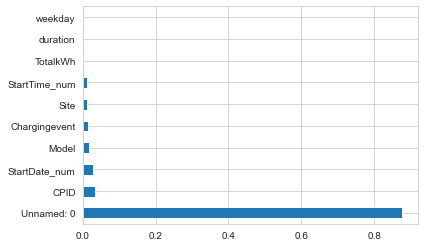

In [42]:
ranked_features = pd.Series(model.feature_importances_ , index = X.columns)
ranked_features.nlargest(n = 10).plot(kind = 'barh')
plt.show()

### 3. Information Gain

In [43]:
from sklearn.feature_selection import mutual_info_classif

In [44]:
mutual_info = mutual_info_classif(X, y)

In [45]:
mutual_data = pd.Series(mutual_info , index = X.columns) 
mutual_data.sort_values(ascending= False)

Unnamed: 0       0.693062
CPID             0.004757
weekday          0.001639
StartTime_num    0.000969
Model            0.000698
StartDate_num    0.000571
duration         0.000065
Chargingevent    0.000000
Connector        0.000000
TotalkWh         0.000000
Site             0.000000
dtype: float64